In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import streamlit as st
import holidays

In [2]:
# Cargar los datasets desde data/raw/entrenamiento y guardarlos como dataframes
# Rutas relativas (Windows o POSIX funcionan con pandas)
competencia_path = '../data/raw/entrenamiento/competencia.csv'
ventas_path = '../data/raw/entrenamiento/ventas.csv'

try:
    df_competencia = pd.read_csv(competencia_path, encoding='utf-8')
    print(f"Cargado 'competencia': shape={df_competencia.shape}")
except Exception as e:
    print(f"Error al leer {competencia_path}: {e}")
    df_competencia = None

try:
    df_ventas = pd.read_csv(ventas_path, encoding='utf-8')
    print(f"Cargado 'ventas': shape={df_ventas.shape}")
except Exception as e:
    print(f"Error al leer {ventas_path}: {e}")
    df_ventas = None

# Mostrar primeras filas para verificación
if df_competencia is not None:
    display(df_competencia.head())
if df_ventas is not None:
    display(df_ventas.head())

# Variables disponibles: df_competencia, df_ventas

Cargado 'competencia': shape=(3552, 5)
Cargado 'ventas': shape=(3552, 10)


,fecha,producto_id,Amazon,Decathlon,Deporvillage
0,2021-10-25,PROD_001,82.96,111.88,97.43
1,2021-10-25,PROD_002,112.56,108.61,115.58
2,2021-10-25,PROD_003,79.79,78.44,80.11
3,2021-10-25,PROD_004,72.60,67.29,74.45
4,2021-10-25,PROD_005,37.71,33.60,33.07


,fecha,producto_id,nombre,categoria,subcategoria,precio_base,es_estrella,unidades_vendidas,precio_venta,ingresos
0,2021-10-25,PROD_001,Nike Air Zoom Pegasus 40,Running,Zapatillas Running,115,True,6,118.36,710.16
1,2021-10-25,PROD_002,Adidas Ultraboost 23,Running,Zapatillas Running,135,True,10,136.82,1368.20
2,2021-10-25,PROD_003,Asics Gel Nimbus 25,Running,Zapatillas Running,85,False,2,84.93,169.86
3,2021-10-25,PROD_004,New Balance Fresh Foam X 1080v12,Running,Zapatillas Running,75,False,2,75.42,150.84
4,2021-10-25,PROD_005,Nike Dri-FIT Miler,Running,Ropa Running,35,False,2,35.87,71.74


In [3]:
df_competencia.columns

Index(['fecha', 'producto_id', 'Amazon', 'Decathlon', 'Deporvillage'], dtype='object')

In [4]:
df_ventas.columns

Index(['fecha', 'producto_id', 'nombre', 'categoria', 'subcategoria',
       'precio_base', 'es_estrella', 'unidades_vendidas', 'precio_venta',
       'ingresos'],
      dtype='object')

In [5]:
# 1️⃣ Información general
print("📊 INFORMACIÓN GENERAL")
print("="*50)
print(f"Filas: {df_ventas.shape[0]} | Columnas: {df_ventas.shape[1]}")
print("\nTipos de datos:\n")
print(df_ventas.dtypes)
print("\nValores nulos totales por columna:\n")
print(df_ventas.isnull().sum())
print("\nPorcentaje de valores nulos (%):\n")
print(round(df_ventas.isnull().mean() * 100, 2))

# 2️⃣ Análisis de duplicados
print("\n🧩 ANÁLISIS DE DUPLICADOS")
print("="*50)
duplicados = df_ventas.duplicated().sum()
print(f"Número de filas duplicadas: {duplicados}")
if duplicados > 0:
    print("Ejemplo de duplicados:")
    display(df_ventas[df_ventas.duplicated()].head())

# 3️⃣ Valores únicos y cardinalidad
print("\n🔢 VALORES ÚNICOS Y CARDINALIDAD")
print("="*50)
valores_unicos = df_ventas.nunique().sort_values(ascending=True)
tabla_unicos = pd.DataFrame({
    'n_unicos': valores_unicos,
    'porcentaje_unicos': round(valores_unicos / len(df_ventas) * 100, 2)
})
display(tabla_unicos)

# 4️⃣ Distribución de variables numéricas
print("\n📈 DESCRIPCIÓN VARIABLES NUMÉRICAS")
print("="*50)
display(df_ventas.describe().T)

# 5️⃣ Distribución de variables categóricas
print("\n🏷️ DESCRIPCIÓN VARIABLES CATEGÓRICAS")
print("="*50)
cat_cols = df_ventas.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\nColumna: {col}")
    print(df_ventas[col].value_counts(dropna=False).head(5))
    print("-"*50)

# 6️⃣ Análisis de outliers básicos (solo numéricas)
print("\n🚨 ANÁLISIS DE OUTLIERS (IQR method)")
print("="*50)
numeric_cols = df_ventas.select_dtypes(include=np.number).columns
outlier_summary = {}

for col in numeric_cols:
    Q1 = df_ventas[col].quantile(0.25)
    Q3 = df_ventas[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outliers = ((df_ventas[col] < lower) | (df_ventas[col] > upper)).sum()
    outlier_summary[col] = round(outliers / len(df_ventas) * 100, 2)

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['%_outliers'])
display(outlier_df.sort_values('%_outliers', ascending=False))

# 7️⃣ Recomendaciones automáticas (opcional)
print("\n💡 RECOMENDACIONES AUTOMÁTICAS")
print("="*50)
if df_ventas.isnull().any().any():
    print("- Hay columnas con valores nulos, considera imputarlas o eliminarlas según su relevancia.")
if duplicados > 0:
    print("- Existen filas duplicadas, revisar si son errores o ventas repetidas.")
if (outlier_df['%_outliers'] > 5).any():
    print("- Se detectan posibles outliers en variables numéricas, revisar distribución.")
if any(df_ventas.nunique() == 1):
    print("- Hay columnas con un único valor, pueden eliminarse por no aportar información.")
print("✅ Revisión de calidad de datos completada.")

📊 INFORMACIÓN GENERAL
Filas: 3552 | Columnas: 10

Tipos de datos:

fecha                 object
producto_id           object
nombre                object
categoria             object
subcategoria          object
precio_base            int64
es_estrella             bool
unidades_vendidas      int64
precio_venta         float64
ingresos             float64
dtype: object

Valores nulos totales por columna:

fecha                0
producto_id          0
nombre               0
categoria            0
subcategoria         0
precio_base          0
es_estrella          0
unidades_vendidas    0
precio_venta         0
ingresos             0
dtype: int64

Porcentaje de valores nulos (%):

fecha                0.0
producto_id          0.0
nombre               0.0
categoria            0.0
subcategoria         0.0
precio_base          0.0
es_estrella          0.0
unidades_vendidas    0.0
precio_venta         0.0
ingresos             0.0
dtype: float64

🧩 ANÁLISIS DE DUPLICADOS
Número de filas duplica

,n_unicos,porcentaje_unicos
es_estrella,2,0.06
categoria,4,0.11
subcategoria,16,0.45
precio_base,21,0.59
producto_id,24,0.68
nombre,24,0.68
unidades_vendidas,52,1.46
fecha,148,4.17
precio_venta,2537,71.42
ingresos,3033,85.39



📈 DESCRIPCIÓN VARIABLES NUMÉRICAS


,count,mean,std,min,25%,50%,75%,max
precio_base,3552.0,123.125000,165.576753,20.00,48.7500,72.50,118.7500,830.00
unidades_vendidas,3552.0,4.878660,6.311020,1.00,2.0000,3.00,5.0000,85.00
precio_venta,3552.0,121.816546,164.017963,19.00,47.2125,71.81,118.2200,854.22
ingresos,3552.0,605.972323,1079.071192,19.46,131.5350,216.57,639.6375,14508.40



🏷️ DESCRIPCIÓN VARIABLES CATEGÓRICAS

Columna: fecha
fecha
2021-10-25    24
2021-10-26    24
2021-10-27    24
2021-10-28    24
2021-10-29    24
Name: count, dtype: int64
--------------------------------------------------

Columna: producto_id
producto_id
PROD_001    148
PROD_002    148
PROD_003    148
PROD_004    148
PROD_005    148
Name: count, dtype: int64
--------------------------------------------------

Columna: nombre
nombre
Nike Air Zoom Pegasus 40            148
Adidas Ultraboost 23                148
Asics Gel Nimbus 25                 148
New Balance Fresh Foam X 1080v12    148
Nike Dri-FIT Miler                  148
Name: count, dtype: int64
--------------------------------------------------

Columna: categoria
categoria
Running     1184
Fitness      888
Outdoor      888
Wellness     592
Name: count, dtype: int64
--------------------------------------------------

Columna: subcategoria
subcategoria
Zapatillas Running    888
Ropa Running          296
Ropa Montaña          2

,%_outliers
unidades_vendidas,13.12
ingresos,11.40
precio_base,8.33
precio_venta,8.33



💡 RECOMENDACIONES AUTOMÁTICAS
- Se detectan posibles outliers en variables numéricas, revisar distribución.
✅ Revisión de calidad de datos completada.


In [6]:
# 1️⃣ Información general
print("📊 INFORMACIÓN GENERAL")
print("="*50)
print(f"Filas: {df_competencia.shape[0]} | Columnas: {df_competencia.shape[1]}")
print("\nTipos de datos:\n")
print(df_competencia.dtypes)
print("\nValores nulos totales por columna:\n")
print(df_competencia.isnull().sum())
print("\nPorcentaje de valores nulos (%):\n")
print(round(df_competencia.isnull().mean() * 100, 2))

# 2️⃣ Análisis de duplicados
print("\n🧩 ANÁLISIS DE DUPLICADOS")
print("="*50)
duplicados = df_competencia.duplicated().sum()
print(f"Número de filas duplicadas: {duplicados}")
if duplicados > 0:
    print("Ejemplo de duplicados:")
    display(df_competencia[df_competencia.duplicated()].head())

# 3️⃣ Valores únicos y cardinalidad
print("\n🔢 VALORES ÚNICOS Y CARDINALIDAD")
print("="*50)
valores_unicos = df_competencia.nunique().sort_values(ascending=True)
tabla_unicos = pd.DataFrame({
    'n_unicos': valores_unicos,
    'porcentaje_unicos': round(valores_unicos / len(df_competencia) * 100, 2)
})
display(tabla_unicos)

# 4️⃣ Distribución de variables numéricas
print("\n📈 DESCRIPCIÓN VARIABLES NUMÉRICAS")
print("="*50)
display(df_competencia.describe().T)

# 5️⃣ Distribución de variables categóricas
print("\n🏷️ DESCRIPCIÓN VARIABLES CATEGÓRICAS")
print("="*50)
cat_cols = df_competencia.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\nColumna: {col}")
    print(df_competencia[col].value_counts(dropna=False).head(5))
    print("-"*50)

# 6️⃣ Análisis de outliers básicos (solo numéricas)
print("\n🚨 ANÁLISIS DE OUTLIERS (IQR method)")
print("="*50)
numeric_cols = df_competencia.select_dtypes(include=np.number).columns
outlier_summary = {}

for col in numeric_cols:
    Q1 = df_competencia[col].quantile(0.25)
    Q3 = df_competencia[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outliers = ((df_competencia[col] < lower) | (df_competencia[col] > upper)).sum()
    outlier_summary[col] = round(outliers / len(df_competencia) * 100, 2)

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['%_outliers'])
display(outlier_df.sort_values('%_outliers', ascending=False))

# 7️⃣ Recomendaciones automáticas (opcional)
print("\n💡 RECOMENDACIONES AUTOMÁTICAS")
print("="*50)
if df_competencia.isnull().any().any():
    print("- Hay columnas con valores nulos, considera imputarlas o eliminarlas según su relevancia.")
if duplicados > 0:
    print("- Existen filas duplicadas, revisar si son errores o registros redundantes.")
if (outlier_df['%_outliers'] > 5).any():
    print("- Se detectan posibles outliers en variables numéricas, revisar distribución.")
if any(df_competencia.nunique() == 1):
    print("- Hay columnas con un único valor, pueden eliminarse por no aportar información.")
print("✅ Revisión de calidad de datos completada.")

📊 INFORMACIÓN GENERAL
Filas: 3552 | Columnas: 5

Tipos de datos:

fecha            object
producto_id      object
Amazon          float64
Decathlon       float64
Deporvillage    float64
dtype: object

Valores nulos totales por columna:

fecha           0
producto_id     0
Amazon          0
Decathlon       0
Deporvillage    0
dtype: int64

Porcentaje de valores nulos (%):

fecha           0.0
producto_id     0.0
Amazon          0.0
Decathlon       0.0
Deporvillage    0.0
dtype: float64

🧩 ANÁLISIS DE DUPLICADOS
Número de filas duplicadas: 0

🔢 VALORES ÚNICOS Y CARDINALIDAD


,n_unicos,porcentaje_unicos
producto_id,24,0.68
fecha,148,4.17
Decathlon,3001,84.49
Deporvillage,3105,87.42
Amazon,3125,87.98



📈 DESCRIPCIÓN VARIABLES NUMÉRICAS


,count,mean,std,min,25%,50%,75%,max
Amazon,3552.0,118.623407,156.095628,16.85,47.1175,73.180,114.3425,858.3500
Decathlon,3552.0,111.412182,148.508132,15.45,43.2850,66.285,111.1725,867.3375
Deporvillage,3552.0,118.894628,160.216448,16.77,47.3100,72.700,114.9850,932.3250



🏷️ DESCRIPCIÓN VARIABLES CATEGÓRICAS

Columna: fecha
fecha
2021-10-25    24
2021-10-26    24
2021-10-27    24
2021-10-28    24
2021-10-29    24
Name: count, dtype: int64
--------------------------------------------------

Columna: producto_id
producto_id
PROD_001    148
PROD_002    148
PROD_003    148
PROD_004    148
PROD_005    148
Name: count, dtype: int64
--------------------------------------------------

🚨 ANÁLISIS DE OUTLIERS (IQR method)


,%_outliers
Amazon,8.33
Decathlon,8.33
Deporvillage,8.33



💡 RECOMENDACIONES AUTOMÁTICAS
- Se detectan posibles outliers en variables numéricas, revisar distribución.
✅ Revisión de calidad de datos completada.


In [7]:
# COMPARACIÓN ENTRE DF_VENTAS Y DF_COMPETENCIA
print("📊 COMPARATIVA ESTRUCTURAL ENTRE DATASETS")
print("="*50)
comparativa = pd.DataFrame({
    'columnas_df_ventas': df_ventas.columns,
    'tipo_df_ventas': df_ventas.dtypes.values,
})
comparativa_comp = pd.DataFrame({
    'columnas_df_competencia': df_competencia.columns,
    'tipo_df_competencia': df_competencia.dtypes.values,
})
display(comparativa)
display(comparativa_comp)


📊 COMPARATIVA ESTRUCTURAL ENTRE DATASETS


,columnas_df_ventas,tipo_df_ventas
0,fecha,object
1,producto_id,object
2,nombre,object
3,categoria,object
4,subcategoria,object
5,precio_base,int64
6,es_estrella,bool
7,unidades_vendidas,int64
8,precio_venta,float64
9,ingresos,float64


,columnas_df_competencia,tipo_df_competencia
0,fecha,object
1,producto_id,object
2,Amazon,float64
3,Decathlon,float64
4,Deporvillage,float64


In [8]:
# ================================================
# CONVERSIÓN DE COLUMNA FECHA A FORMATO DATETIME
# ================================================

# Convertir 'fecha' en df_ventas
if 'fecha' in df_ventas.columns:
    df_ventas['fecha'] = pd.to_datetime(df_ventas['fecha'], errors='coerce', dayfirst=True)
    print("✅ Columna 'fecha' convertida a datetime en df_ventas.")
    print(df_ventas['fecha'].dtypes)
    print(df_ventas['fecha'].head())
else:
    print("⚠️ No se encontró columna 'fecha' en df_ventas.")

# Convertir 'fecha' en df_competencia
if 'fecha' in df_competencia.columns:
    df_competencia['fecha'] = pd.to_datetime(df_competencia['fecha'], errors='coerce', dayfirst=True)
    print("✅ Columna 'fecha' convertida a datetime en df_competencia.")
    print(df_competencia['fecha'].dtypes)
    print(df_competencia['fecha'].head())
else:
    print("⚠️ No se encontró columna 'fecha' en df_competencia.")


✅ Columna 'fecha' convertida a datetime en df_ventas.
datetime64[ns]
0   2021-10-25
1   2021-10-25
2   2021-10-25
3   2021-10-25
4   2021-10-25
Name: fecha, dtype: datetime64[ns]
✅ Columna 'fecha' convertida a datetime en df_competencia.
datetime64[ns]
0   2021-10-25
1   2021-10-25
2   2021-10-25
3   2021-10-25
4   2021-10-25
Name: fecha, dtype: datetime64[ns]


C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\2561733586.py:7: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_ventas['fecha'] = pd.to_datetime(df_ventas['fecha'], errors='coerce', dayfirst=True)
C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\2561733586.py:16: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_competencia['fecha'] = pd.to_datetime(df_competencia['fecha'], errors='coerce', dayfirst=True)


In [9]:
# ================================================
# MERGE ENTRE df_ventas Y df_competencia
# Claves: fecha + producto_id
# ================================================

# Verificamos que las columnas clave existen en ambos DataFrames
keys = ['fecha', 'producto_id']
for key in keys:
    if key not in df_ventas.columns:
        print(f"⚠️ La columna '{key}' no está en df_ventas.")
    if key not in df_competencia.columns:
        print(f"⚠️ La columna '{key}' no está en df_competencia.")

# Hacemos el merge (join)
df_merged = pd.merge(
    df_ventas,
    df_competencia,
    on=keys,
    how='inner',   # puedes cambiar a 'left' si quieres mantener todas las ventas aunque falte competencia
    suffixes=('_ventas', '_competencia')
)

# Mostramos resultados
print("✅ Merge completado correctamente.")
print(f"Filas resultantes: {df_merged.shape[0]}")
print(f"Columnas resultantes: {df_merged.shape[1]}")
print("\nVista previa:")
display(df_merged.head())

✅ Merge completado correctamente.
Filas resultantes: 3552
Columnas resultantes: 13

Vista previa:


,fecha,producto_id,nombre,categoria,subcategoria,precio_base,es_estrella,unidades_vendidas,precio_venta,ingresos,Amazon,Decathlon,Deporvillage
0,2021-10-25,PROD_001,Nike Air Zoom Pegasus 40,Running,Zapatillas Running,115,True,6,118.36,710.16,82.96,111.88,97.43
1,2021-10-25,PROD_002,Adidas Ultraboost 23,Running,Zapatillas Running,135,True,10,136.82,1368.20,112.56,108.61,115.58
2,2021-10-25,PROD_003,Asics Gel Nimbus 25,Running,Zapatillas Running,85,False,2,84.93,169.86,79.79,78.44,80.11
3,2021-10-25,PROD_004,New Balance Fresh Foam X 1080v12,Running,Zapatillas Running,75,False,2,75.42,150.84,72.60,67.29,74.45
4,2021-10-25,PROD_005,Nike Dri-FIT Miler,Running,Ropa Running,35,False,2,35.87,71.74,37.71,33.60,33.07


ANALISIS EXPLORATORIO DE DATOS (EDA)

C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\635712313.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


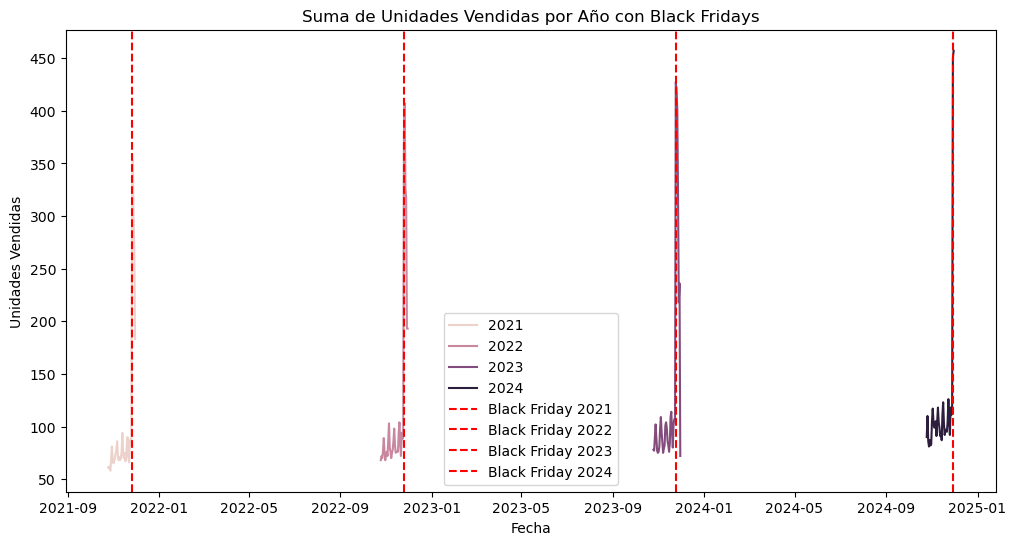

In [10]:
# Gráfico de líneas temporales por año con suma de unidades vendidas y Black Fridays
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Asegurarse de que la columna 'fecha' está en formato datetime
df_merged['fecha'] = pd.to_datetime(df_merged['fecha'], errors='coerce')

# Crear columna de año
df_merged['año'] = df_merged['fecha'].dt.year

# Identificar Black Fridays (último viernes de noviembre)
def black_fridays(year):
    cal = calendar()
    holidays = cal.holidays(start=f'{year}-01-01', end=f'{year}-12-31')
    nov_fridays = pd.date_range(start=f'{year}-11-01', end=f'{year}-11-30', freq='W-FRI')
    return nov_fridays[nov_fridays.isin(holidays) == False][-1]

df_merged['black_friday'] = df_merged['fecha'].apply(lambda x: black_fridays(x.year) if pd.notnull(x) else None)

# Gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_merged,
    x='fecha',
    y='unidades_vendidas',
    hue='año',
    estimator='sum',
    ci=None
)

# Añadir marcadores para Black Fridays
for year in df_merged['año'].dropna().unique():
    bf_date = black_fridays(year)
    if bf_date in df_merged['fecha'].values:
        plt.axvline(x=bf_date, color='red', linestyle='--', label=f'Black Friday {year}')

plt.title('Suma de Unidades Vendidas por Año con Black Fridays')
plt.xlabel('Fecha')
plt.ylabel('Unidades Vendidas')
plt.legend()
plt.show()

In [11]:
# Crear columnas auxiliares
df_merged['anio'] = df_merged['fecha'].dt.year
df_merged['mes'] = df_merged['fecha'].dt.month
df_merged['dia_semana'] = df_merged['fecha'].dt.day_name()

# Definir fechas de Black Friday (último viernes de noviembre de cada año)
black_fridays = {
    2020: '2020-11-27',
    2021: '2021-11-26',
    2022: '2022-11-25',
    2023: '2023-11-24',
    2024: '2024-11-29'
}
black_fridays = pd.to_datetime(list(black_fridays.values()))

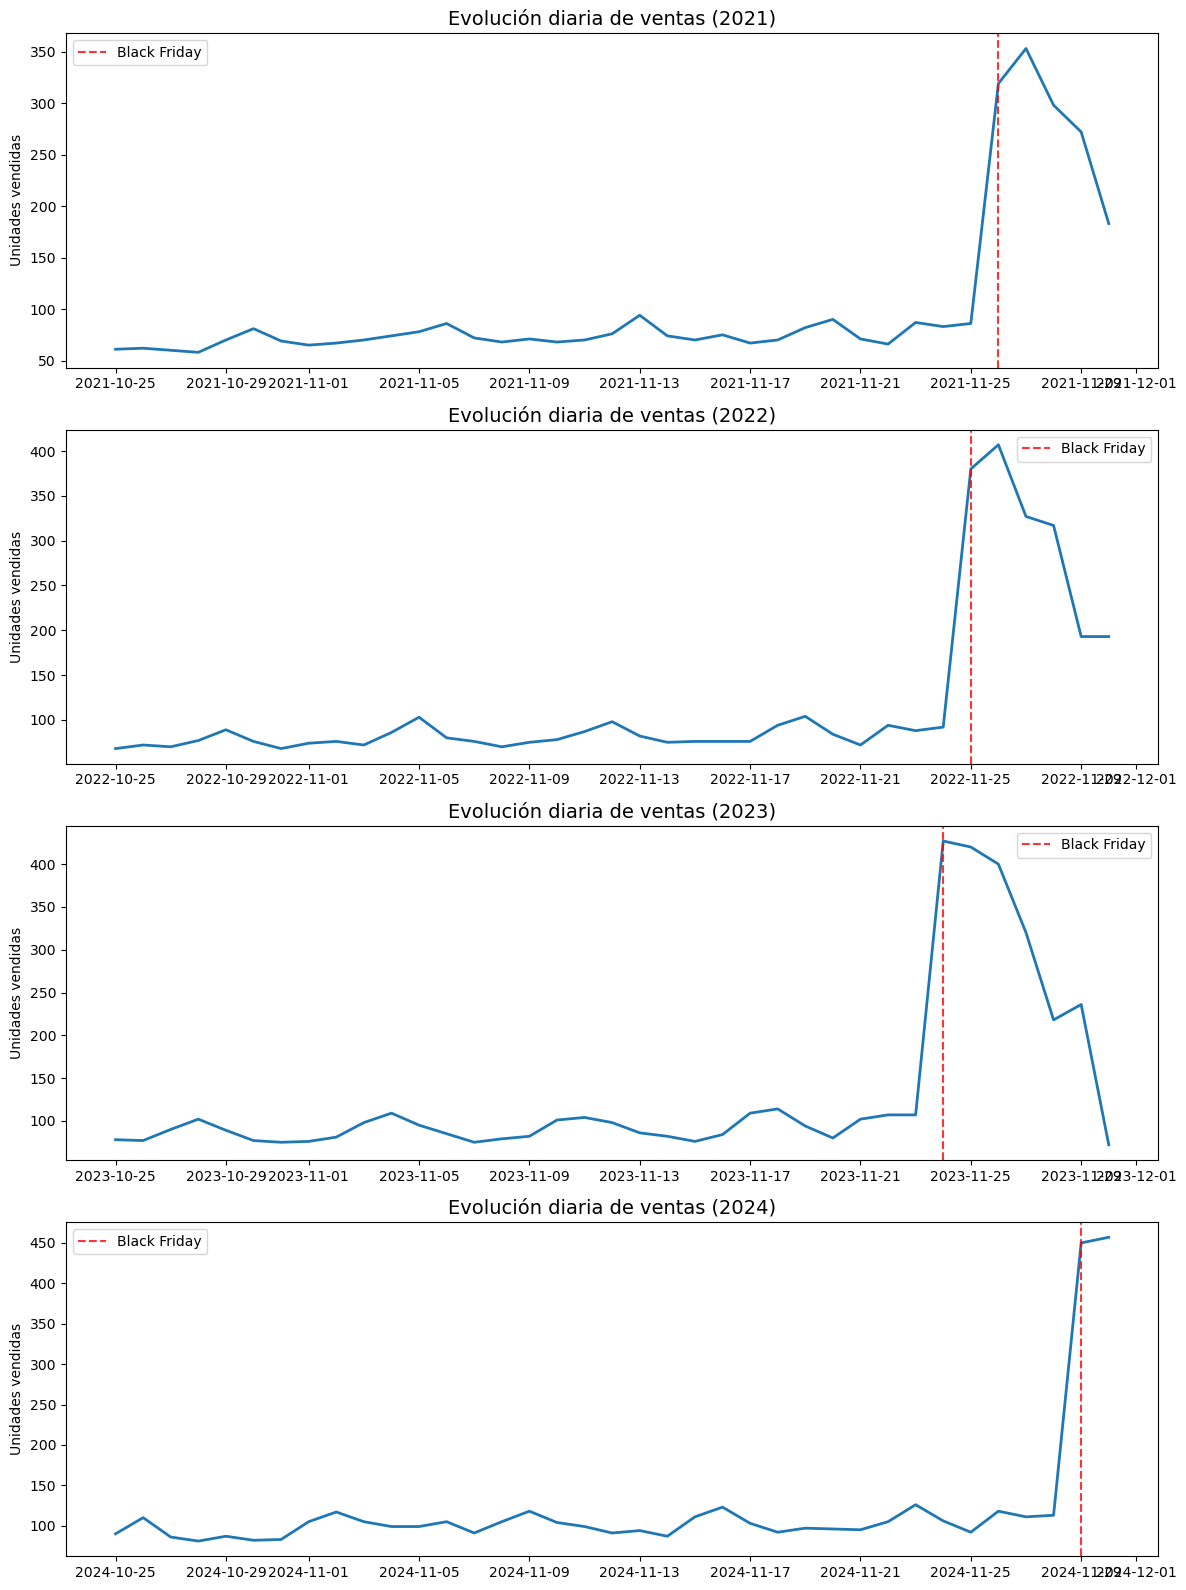

In [12]:
# ================================================
# EVOLUCIÓN TEMPORAL DE UNIDADES VENDIDAS
# ================================================

fig, axes = plt.subplots(nrows=len(df_merged['anio'].unique()), ncols=1, figsize=(12, 4*len(df_merged['anio'].unique())))
if len(df_merged['anio'].unique()) == 1:
    axes = [axes]  # si solo hay un año

for i, year in enumerate(sorted(df_merged['anio'].unique())):
    df_year = df_merged[df_merged['anio'] == year]
    df_daily = df_year.groupby('fecha')['unidades_vendidas'].sum().reset_index()

    sns.lineplot(data=df_daily, x='fecha', y='unidades_vendidas', ax=axes[i], linewidth=2)
    axes[i].set_title(f'Evolución diaria de ventas ({year})', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Unidades vendidas')

    # Marcar Black Friday
    for bf in black_fridays:
        if bf.year == year:
            axes[i].axvline(bf, color='red', linestyle='--', alpha=0.8, label='Black Friday')
    axes[i].legend()

plt.tight_layout()
plt.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\2102280820.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\2102280820.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


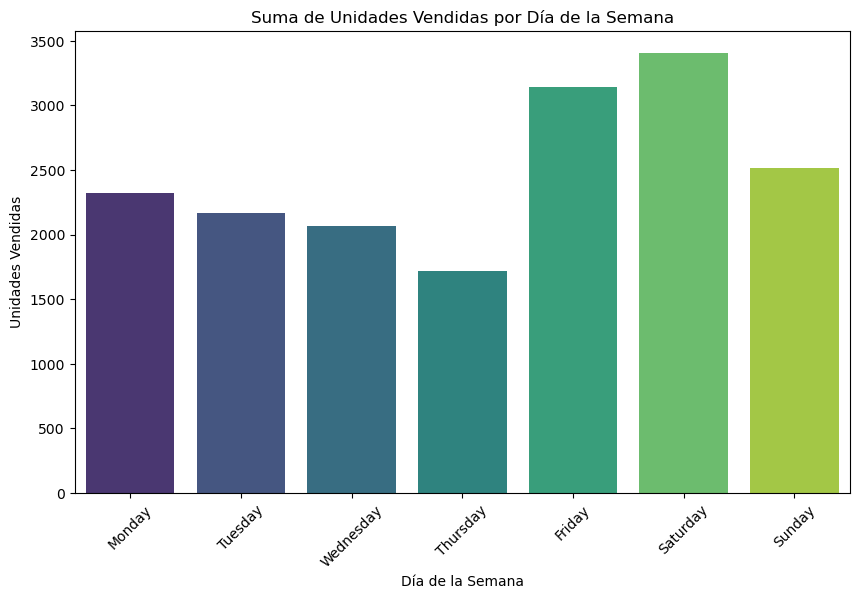

In [13]:
# Gráfico de unidades vendidas por día de la semana
plt.figure(figsize=(10, 6))

# Crear columna con el día de la semana
df_merged['dia_semana'] = df_merged['fecha'].dt.day_name()

# Ordenar días de la semana
dias_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.barplot(
    data=df_merged,
    x='dia_semana',
    y='unidades_vendidas',
    order=dias_ordenados,
    estimator='sum',
    ci=None,
    palette='viridis'
)

plt.title('Suma de Unidades Vendidas por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Unidades Vendidas')
plt.xticks(rotation=45)
plt.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\972756688.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\972756688.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


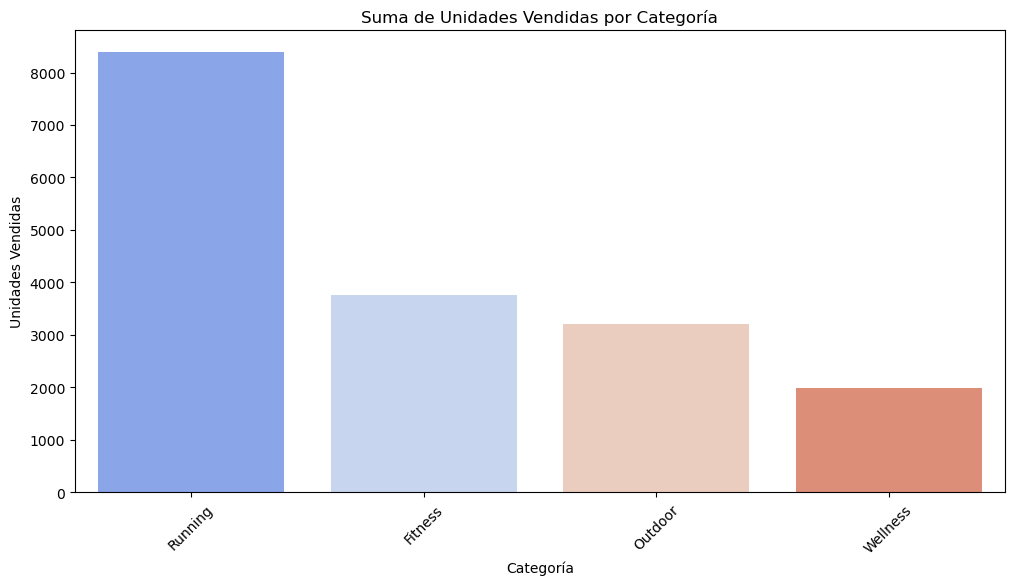

In [14]:
# Gráfico de unidades vendidas por categoría
plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_merged,
    x='categoria',
    y='unidades_vendidas',
    estimator='sum',
    ci=None,
    palette='coolwarm'
)

plt.title('Suma de Unidades Vendidas por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Unidades Vendidas')
plt.xticks(rotation=45)
plt.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\1561011107.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\1561011107.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


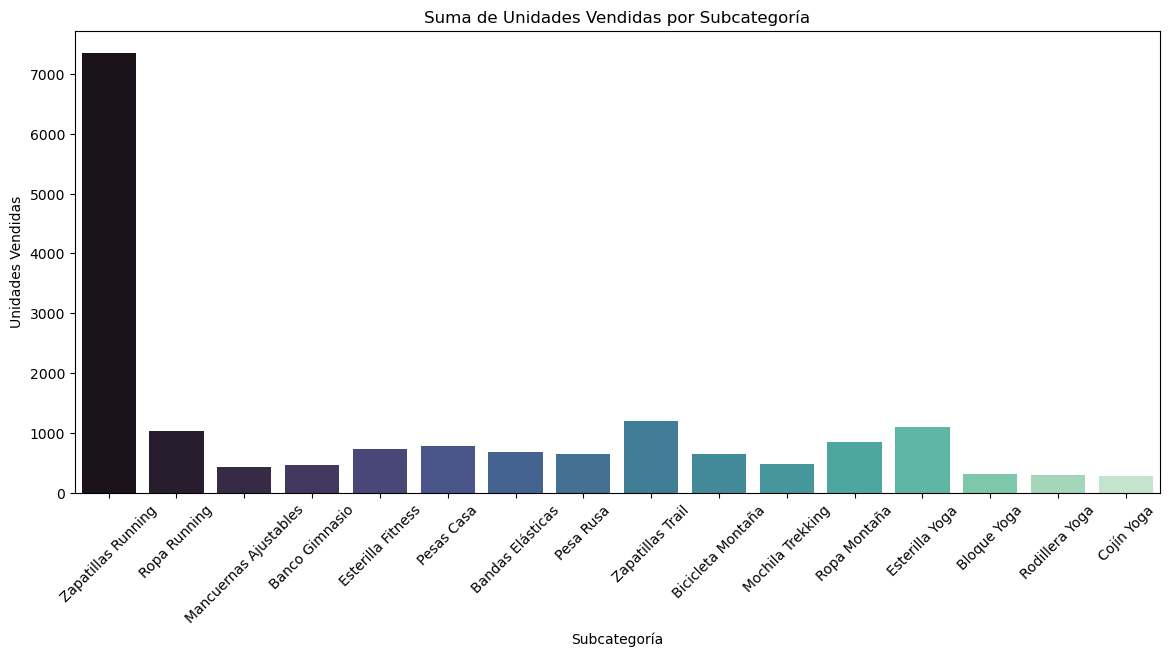

In [15]:
# Gráfico de unidades vendidas por subcategoría
plt.figure(figsize=(14, 6))

sns.barplot(
    data=df_merged,
    x='subcategoria',
    y='unidades_vendidas',
    estimator='sum',
    ci=None,
    palette='mako'
)

plt.title('Suma de Unidades Vendidas por Subcategoría')
plt.xlabel('Subcategoría')
plt.ylabel('Unidades Vendidas')
plt.xticks(rotation=45)
plt.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\1142869430.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


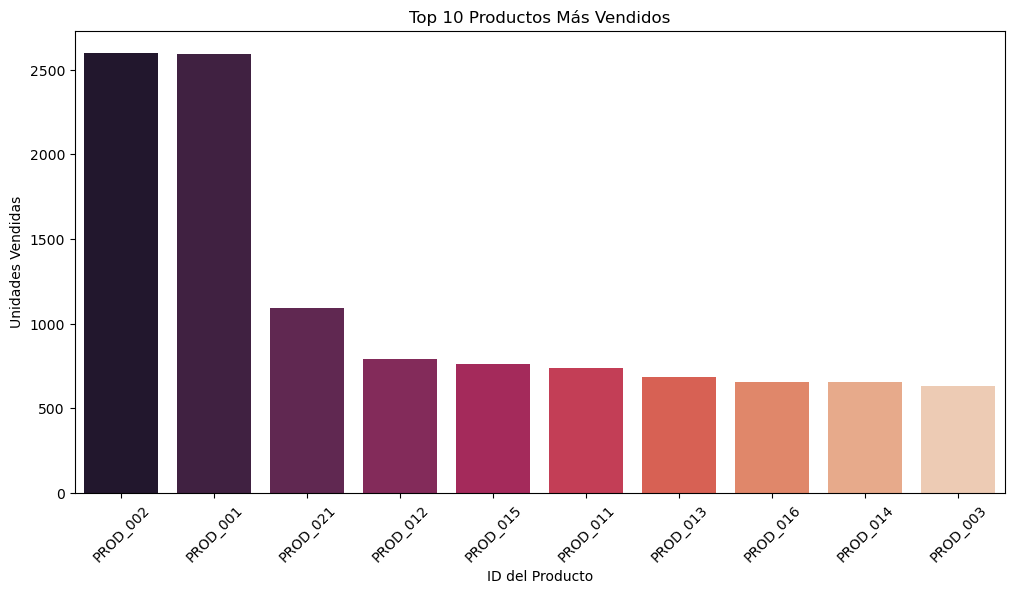

In [16]:
# Gráfico de los productos más vendidos (top productos)
plt.figure(figsize=(12, 6))

# Obtener los 10 productos más vendidos
top_productos = df_merged.groupby('producto_id')['unidades_vendidas'].sum().nlargest(10).reset_index()

sns.barplot(
    data=top_productos,
    x='producto_id',
    y='unidades_vendidas',
    palette='rocket'
)

plt.title('Top 10 Productos Más Vendidos')
plt.xlabel('ID del Producto')
plt.ylabel('Unidades Vendidas')
plt.xticks(rotation=45)
plt.show()

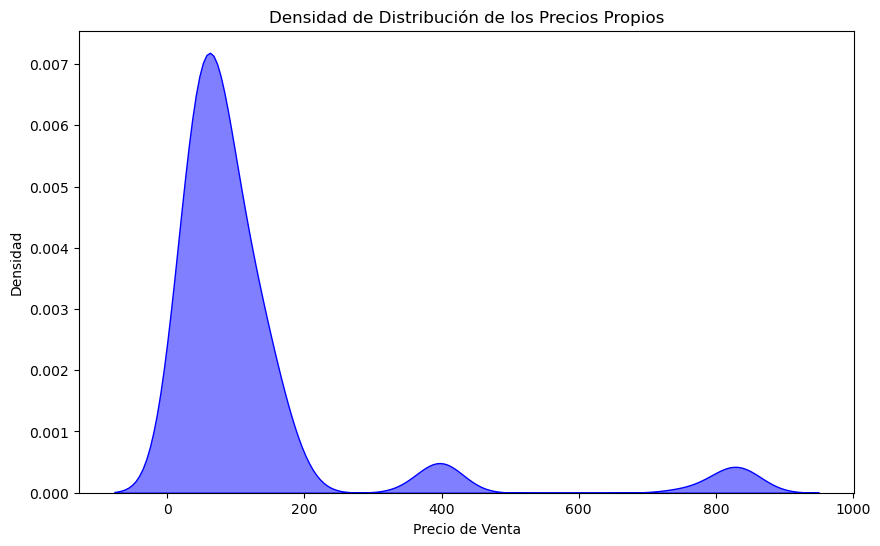

In [17]:
# Análisis de densidad de los precios propios
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=df_merged,
    x='precio_venta',
    fill=True,
    color='blue',
    alpha=0.5
)

plt.title('Densidad de Distribución de los Precios Propios')
plt.xlabel('Precio de Venta')
plt.ylabel('Densidad')
plt.show()

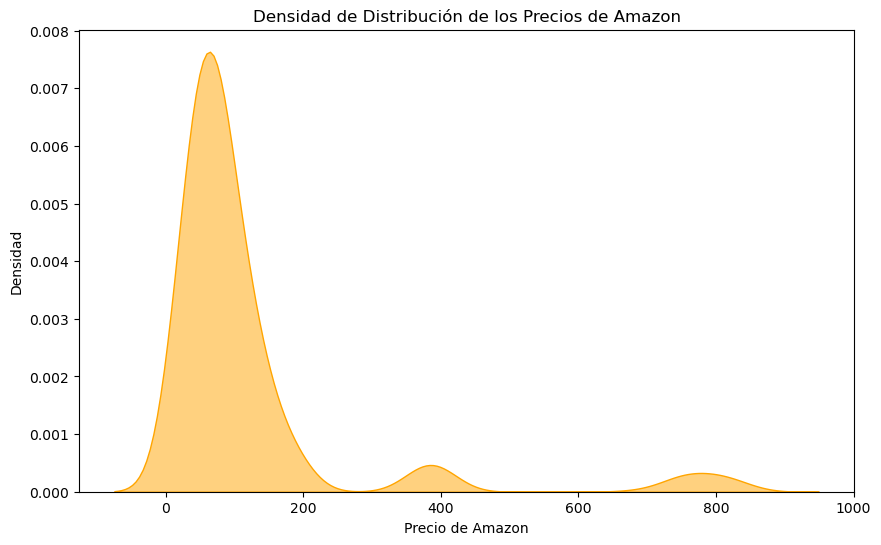

In [18]:
# Análisis de densidad de los precios de Amazon
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=df_merged,
    x='Amazon',
    fill=True,
    color='orange',
    alpha=0.5
)

plt.title('Densidad de Distribución de los Precios de Amazon')
plt.xlabel('Precio de Amazon')
plt.ylabel('Densidad')
plt.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\2197104220.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\2197104220.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


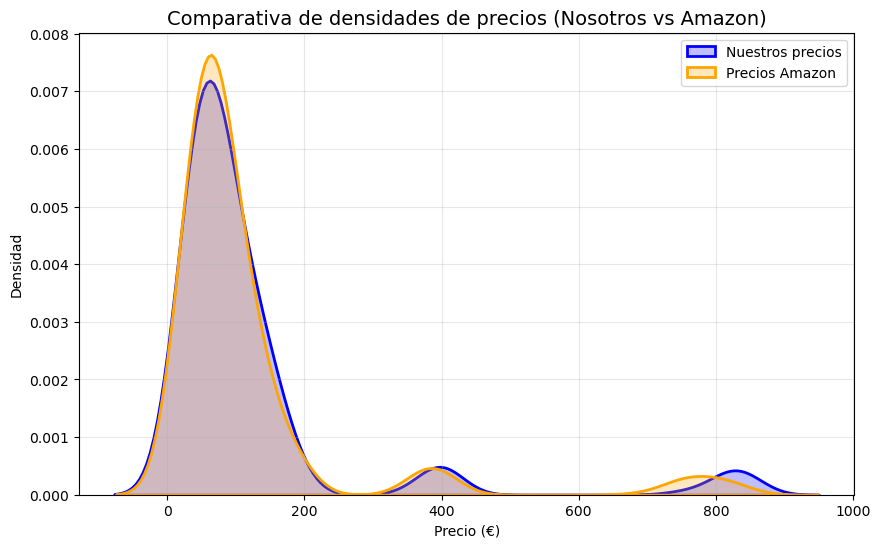

In [19]:
# ================================================
# DENSIDAD COMPARADA DE PRECIOS: Nosotros vs Amazon
# ================================================

plt.figure(figsize=(10,6))

# Densidad de precios propios
sns.kdeplot(
    df_merged['precio_venta'],  # Cambiado de 'precio_ventas' a 'precio_venta'
    shade=True,
    color='blue',
    linewidth=2,
    label='Nuestros precios'
)

# Densidad de precios competencia (Amazon)
sns.kdeplot(
    df_merged['Amazon'],  # Cambiado de 'precio_competencia' a 'Amazon'
    shade=True,
    color='orange',
    linewidth=2,
    label='Precios Amazon'
)

plt.title('Comparativa de densidades de precios (Nosotros vs Amazon)', fontsize=14)
plt.xlabel('Precio (€)')
plt.ylabel('Densidad')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

FASE DE CREACIÓN DE VARIABLES

In [20]:
# Creamos objeto de festivos españoles
festivos_es = holidays.Spain()

# Año, mes, día
df_merged['anio'] = df_merged['fecha'].dt.year
df_merged['mes'] = df_merged['fecha'].dt.month
df_merged['dia_mes'] = df_merged['fecha'].dt.day
df_merged['dia_semana'] = df_merged['fecha'].dt.day_name()
df_merged['semana_anio'] = df_merged['fecha'].dt.isocalendar().week
df_merged['trimestre'] = df_merged['fecha'].dt.quarter

# Fin de semana (sábado o domingo)
df_merged['es_fin_de_semana'] = df_merged['fecha'].dt.dayofweek.isin([5,6])

# Festivo nacional en España
df_merged['es_festivo'] = df_merged['fecha'].isin(festivos_es)

# Black Friday (último viernes de noviembre)
def calcular_black_friday(year):
    nov = pd.date_range(start=f'{year}-11-01', end=f'{year}-11-30', freq='D')
    viernes = nov[nov.dayofweek == 4]
    return viernes.max()

df_merged['es_black_friday'] = df_merged['fecha'].isin(
    [calcular_black_friday(y) for y in df_merged['anio'].unique()]
)

# Cyber Monday (lunes siguiente al Black Friday)
df_merged['es_cyber_monday'] = df_merged['fecha'].isin(
    [calcular_black_friday(y) + pd.Timedelta(days=3) for y in df_merged['anio'].unique()]
)

# Estación del año
def get_estacion(mes):
    if mes in [12, 1, 2]:
        return 'invierno'
    elif mes in [3, 4, 5]:
        return 'primavera'
    elif mes in [6, 7, 8]:
        return 'verano'
    else:
        return 'otoño'

df_merged['estacion'] = df_merged['mes'].apply(get_estacion)

# Periodo pre/post Black Friday (±7 días)
black_fridays = [calcular_black_friday(y) for y in df_merged['anio'].unique()]
df_merged['es_pre_black_friday'] = df_merged['fecha'].isin(
    [d for bf in black_fridays for d in pd.date_range(bf - pd.Timedelta(days=7), bf - pd.Timedelta(days=1))]
)
df_merged['es_post_black_friday'] = df_merged['fecha'].isin(
    [d for bf in black_fridays for d in pd.date_range(bf + pd.Timedelta(days=1), bf + pd.Timedelta(days=7))]
)

# Semana de rebajas (enero y julio)
df_merged['es_rebajas'] = df_merged['mes'].isin([1, 7])

# Indicador de fin de mes (para cierre contable o picos logísticos)
df_merged['es_fin_de_mes'] = df_merged['fecha'].dt.is_month_end

# ================================================
# Verificación rápida
# ================================================
print("✅ Variables temporales creadas correctamente.")
display(df_merged[['fecha','anio','mes','dia_mes','dia_semana','es_fin_de_semana',
                   'es_festivo','es_black_friday','es_cyber_monday',
                   'estacion','es_rebajas','es_pre_black_friday','es_post_black_friday','es_fin_de_mes']].head(10))

✅ Variables temporales creadas correctamente.


,fecha,anio,mes,dia_mes,dia_semana,es_fin_de_semana,es_festivo,es_black_friday,es_cyber_monday,estacion,es_rebajas,es_pre_black_friday,es_post_black_friday,es_fin_de_mes
0,2021-10-25,2021,10,25,Monday,False,False,False,False,otoño,False,False,False,False
1,2021-10-25,2021,10,25,Monday,False,False,False,False,otoño,False,False,False,False
2,2021-10-25,2021,10,25,Monday,False,False,False,False,otoño,False,False,False,False
3,2021-10-25,2021,10,25,Monday,False,False,False,False,otoño,False,False,False,False
4,2021-10-25,2021,10,25,Monday,False,False,False,False,otoño,False,False,False,False
5,2021-10-25,2021,10,25,Monday,False,False,False,False,otoño,False,False,False,False
6,2021-10-25,2021,10,25,Monday,False,False,False,False,otoño,False,False,False,False
7,2021-10-25,2021,10,25,Monday,False,False,False,False,otoño,False,False,False,False
8,2021-10-25,2021,10,25,Monday,False,False,False,False,otoño,False,False,False,False
9,2021-10-25,2021,10,25,Monday,False,False,False,False,otoño,False,False,False,False


In [21]:
# ================================================
# CREACIÓN DE LAGS Y MEDIA MÓVIL
# ================================================
# Crear lags y media móvil por año
def crear_lags_y_media_movil(df):
    # Crear una lista para almacenar los DataFrames procesados por año
    dfs_anuales = []

    for anio in df['anio'].unique():
        # Filtrar el DataFrame por año
        df_anual = df[df['anio'] == anio].copy()
        
        # Crear lags de unidades vendidas (1 al 7)
        for lag in range(1, 8):
            df_anual[f'lag_{lag}'] = df_anual['unidades_vendidas'].shift(lag)
        
        # Crear media móvil de 7 días
        df_anual['media_movil_7'] = df_anual['unidades_vendidas'].rolling(window=7).mean()
        
        # Añadir el DataFrame procesado a la lista
        dfs_anuales.append(df_anual)

    # Concatenar los DataFrames anuales en uno solo
    df_resultado = pd.concat(dfs_anuales)
    
    # Eliminar registros con valores nulos en las nuevas columnas
    columnas_nuevas = [f'lag_{lag}' for lag in range(1, 8)] + ['media_movil_7']
    df_resultado = df_resultado.dropna(subset=columnas_nuevas)
    
    return df_resultado

# Aplicar la función al DataFrame
df_merged = crear_lags_y_media_movil(df_merged)

# Mostrar las primeras filas para verificar
display(df_merged[['fecha', 'unidades_vendidas', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'media_movil_7']].head(10))

,fecha,unidades_vendidas,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,media_movil_7
7,2021-10-25,2,2.0,2.0,2.0,2.0,2.0,10.0,6.0,3.142857
8,2021-10-25,2,2.0,2.0,2.0,2.0,2.0,2.0,10.0,2.000000
9,2021-10-25,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.000000
10,2021-10-25,3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.142857
11,2021-10-25,3,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.285714
12,2021-10-25,2,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.285714
13,2021-10-25,2,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.285714
14,2021-10-25,3,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.428571
15,2021-10-25,2,3.0,2.0,2.0,3.0,3.0,2.0,2.0,2.428571
16,2021-10-25,1,2.0,3.0,2.0,2.0,3.0,3.0,2.0,2.285714


In [22]:
df_merged.shape

(3524, 38)

In [23]:
df_merged.groupby('año').size()

año
2021    881
2022    881
2023    881
2024    881
dtype: int64

Si se ve que está diferenciando el fin de un año con el principio del siguiente.

In [24]:
# ================================================
# CREACIÓN DE VARIABLE DE DESCUENTO PORCENTAJE
# ================================================
# Calcular el porcentaje de descuento
df_merged['descuento_porcentaje'] = ((df_merged['precio_base'] - df_merged['precio_venta']) / df_merged['precio_base']) * 100

# Mostrar las primeras filas para verificar
display(df_merged[['fecha', 'precio_base', 'precio_venta', 'descuento_porcentaje']].head(10))

,fecha,precio_base,precio_venta,descuento_porcentaje
7,2021-10-25,65,66.60,-2.461538
8,2021-10-25,400,392.31,1.922500
9,2021-10-25,175,174.92,0.045714
10,2021-10-25,45,44.32,1.511111
11,2021-10-25,55,55.05,-0.090909
12,2021-10-25,25,24.79,0.840000
13,2021-10-25,40,39.74,0.650000
14,2021-10-25,150,154.22,-2.813333
15,2021-10-25,830,821.29,1.049398
16,2021-10-25,95,96.56,-1.642105


In [25]:
# ================================================
# CREACIÓN DE VARIABLES DE COMPETENCIA
# ================================================
# Calcular el precio promedio de los competidores
df_merged['precio_competencia'] = df_merged[['Amazon', 'Decathlon', 'Deporvillage']].mean(axis=1)

# Calcular el ratio de nuestro precio respecto al precio promedio de la competencia
df_merged['ratio_precio'] = df_merged['precio_venta'] / df_merged['precio_competencia']

# Eliminar las columnas de los competidores
df_merged = df_merged.drop(columns=['Amazon', 'Decathlon', 'Deporvillage'])

# Mostrar las primeras filas para verificar
display(df_merged[['fecha', 'precio_venta', 'precio_competencia', 'ratio_precio']].head(10))

,fecha,precio_venta,precio_competencia,ratio_precio
7,2021-10-25,66.60,64.346667,1.035019
8,2021-10-25,392.31,350.850000,1.118170
9,2021-10-25,174.92,160.156667,1.092181
10,2021-10-25,44.32,44.563333,0.994540
11,2021-10-25,55.05,53.246667,1.033868
12,2021-10-25,24.79,24.096667,1.028773
13,2021-10-25,39.74,39.460000,1.007096
14,2021-10-25,154.22,135.673333,1.136701
15,2021-10-25,821.29,735.070000,1.117295
16,2021-10-25,96.56,92.636667,1.042352


In [26]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3524 entries, 7 to 3551
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   fecha                 3524 non-null   datetime64[ns]
 1   producto_id           3524 non-null   object        
 2   nombre                3524 non-null   object        
 3   categoria             3524 non-null   object        
 4   subcategoria          3524 non-null   object        
 5   precio_base           3524 non-null   int64         
 6   es_estrella           3524 non-null   bool          
 7   unidades_vendidas     3524 non-null   int64         
 8   precio_venta          3524 non-null   float64       
 9   ingresos              3524 non-null   float64       
 10  año                   3524 non-null   int32         
 11  black_friday          3524 non-null   datetime64[ns]
 12  anio                  3524 non-null   int32         
 13  mes                   3

In [27]:
# ================================================
# CREACIÓN DE VARIABLES CON SUFIJO Y ONE-HOT ENCODING
# ================================================
# Crear copias de las variables con sufijo '_h'
df_merged['nombre_h'] = df_merged['nombre']
df_merged['categoria_h'] = df_merged['categoria']
df_merged['subcategoria_h'] = df_merged['subcategoria']

# Aplicar One-hot encoding a las variables con sufijo '_h'
df_merged = pd.get_dummies(df_merged, columns=['nombre_h', 'categoria_h', 'subcategoria_h'], drop_first=True)

# Mostrar las primeras filas para verificar
display(df_merged.head(10))

,fecha,producto_id,nombre,categoria,subcategoria,precio_base,es_estrella,unidades_vendidas,precio_venta,ingresos,...,subcategoria_h_Esterilla Yoga,subcategoria_h_Mancuernas Ajustables,subcategoria_h_Mochila Trekking,subcategoria_h_Pesa Rusa,subcategoria_h_Pesas Casa,subcategoria_h_Rodillera Yoga,subcategoria_h_Ropa Montaña,subcategoria_h_Ropa Running,subcategoria_h_Zapatillas Running,subcategoria_h_Zapatillas Trail
7,2021-10-25,PROD_008,Reebok Floatride Energy 5,Running,Zapatillas Running,65,False,2,66.60,133.20,...,False,False,False,False,False,False,False,False,True,False
8,2021-10-25,PROD_009,Bowflex SelectTech 552,Fitness,Mancuernas Ajustables,400,True,2,392.31,784.62,...,False,True,False,False,False,False,False,False,False,False
9,2021-10-25,PROD_010,Domyos BM900,Fitness,Banco Gimnasio,175,True,2,174.92,349.84,...,False,False,False,False,False,False,False,False,False,False
10,2021-10-25,PROD_011,Reebok Professional Deck,Fitness,Esterilla Fitness,45,False,3,44.32,132.96,...,False,False,False,False,False,False,False,False,False,False
11,2021-10-25,PROD_012,Domyos Kit Mancuernas 20kg,Fitness,Pesas Casa,55,False,3,55.05,165.15,...,False,False,False,False,True,False,False,False,False,False
12,2021-10-25,PROD_013,Decathlon Bandas Elásticas Set,Fitness,Bandas Elásticas,25,False,2,24.79,49.58,...,False,False,False,False,False,False,False,False,False,False
13,2021-10-25,PROD_014,Sveltus Kettlebell 12kg,Fitness,Pesa Rusa,40,False,2,39.74,79.48,...,False,False,False,True,False,False,False,False,False,False
14,2021-10-25,PROD_015,Salomon Speedcross 5 GTX,Outdoor,Zapatillas Trail,150,True,3,154.22,462.66,...,False,False,False,False,False,False,False,False,False,True
15,2021-10-25,PROD_016,Trek Marlin 7,Outdoor,Bicicleta Montaña,830,True,2,821.29,1642.58,...,False,False,False,False,False,False,False,False,False,False
16,2021-10-25,PROD_017,The North Face Borealis,Outdoor,Mochila Trekking,95,False,1,96.56,96.56,...,False,False,True,False,False,False,False,False,False,False


In [28]:
# ================================================
# GUARDAR DATAFRAME PROCESADO
# ================================================
# Guardar el DataFrame procesado en la carpeta data/processed
output_path = '../data/processed/df_merged.csv'

df_merged.to_csv(output_path, index=False, encoding='utf-8')
print(f"✅ DataFrame guardado correctamente en: {output_path}")

✅ DataFrame guardado correctamente en: ../data/processed/df_merged.csv


In [29]:
# ================================================
# DIVISIÓN DEL DATAFRAME EN ENTRENAMIENTO Y VALIDACIÓN
# ================================================
# Crear df_train con datos entre 2021 y 2023
df_train = df_merged[(df_merged['anio'] >= 2021) & (df_merged['anio'] <= 2023)]

# Crear df_validation con datos de 2024
df_validation = df_merged[df_merged['anio'] == 2024]

# Mostrar el número de registros en cada conjunto
print(f"Registros en df_train (2021-2023): {len(df_train)}")
print(f"Registros en df_validation (2024): {len(df_validation)}")

Registros en df_train (2021-2023): 2643
Registros en df_validation (2024): 881


In [30]:
# ================================================
# ENTRENAMIENTO Y VALIDACIÓN DE HistGradientBoostingRegressor
# ================================================
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Definir las columnas predictoras y la target
predictoras = [col for col in df_train.columns if col not in ['fecha', 'ingresos', 'unidades_vendidas'] and df_train[col].dtype != 'object']
target = 'unidades_vendidas'

# Dividir los datos en X (predictoras) e y (target)
X_train = df_train[predictoras].select_dtypes(include=[np.number])
y_train = df_train[target]
X_validation = df_validation[predictoras].select_dtypes(include=[np.number])
y_validation = df_validation[target]

# Entrenar el modelo HistGradientBoostingRegressor con parámetros conservadores
modelo = HistGradientBoostingRegressor(
    learning_rate=0.01,
    max_iter=500,
    max_depth=10,
    l2_regularization=1.0,
    random_state=42
)
modelo.fit(X_train, y_train)

# Predicciones del modelo
y_pred_train = modelo.predict(X_train)
y_pred_validation = modelo.predict(X_validation)

# Baseline naive: predice la media del target en el conjunto de entrenamiento
baseline_pred = np.full(len(y_validation), y_train.mean())

# Calcular métricas para el modelo y el baseline
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

mse_train, mae_train, rmse_train, r2_train = calcular_metricas(y_train, y_pred_train)
mse_val, mae_val, rmse_val, r2_val = calcular_metricas(y_validation, y_pred_validation)
mse_baseline, mae_baseline, rmse_baseline, r2_baseline = calcular_metricas(y_validation, baseline_pred)

# Mostrar resultados
print("\n📊 MÉTRICAS DEL MODELO (TRAIN)")
print(f"MSE: {mse_train:.2f} | MAE: {mae_train:.2f} | RMSE: {rmse_train:.2f} | R2: {r2_train:.2f}")
print("\n📊 MÉTRICAS DEL MODELO (VALIDATION)")
print(f"MSE: {mse_val:.2f} | MAE: {mae_val:.2f} | RMSE: {rmse_val:.2f} | R2: {r2_val:.2f}")
print("\n📊 MÉTRICAS DEL BASELINE (VALIDATION)")
print(f"MSE: {mse_baseline:.2f} | MAE: {mae_baseline:.2f} | RMSE: {rmse_baseline:.2f} | R2: {r2_baseline:.2f}")

c:\Users\heatb\anaconda3\envs\Forecasting\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(



📊 MÉTRICAS DEL MODELO (TRAIN)
MSE: 1.51 | MAE: 0.52 | RMSE: 1.23 | R2: 0.96

📊 MÉTRICAS DEL MODELO (VALIDATION)
MSE: 3.41 | MAE: 0.77 | RMSE: 1.85 | R2: 0.91

📊 MÉTRICAS DEL BASELINE (VALIDATION)
MSE: 39.09 | MAE: 3.34 | RMSE: 6.25 | R2: -0.00


C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\45790094.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nov_2024['predicciones'] = modelo.predict(X_nov_2024)


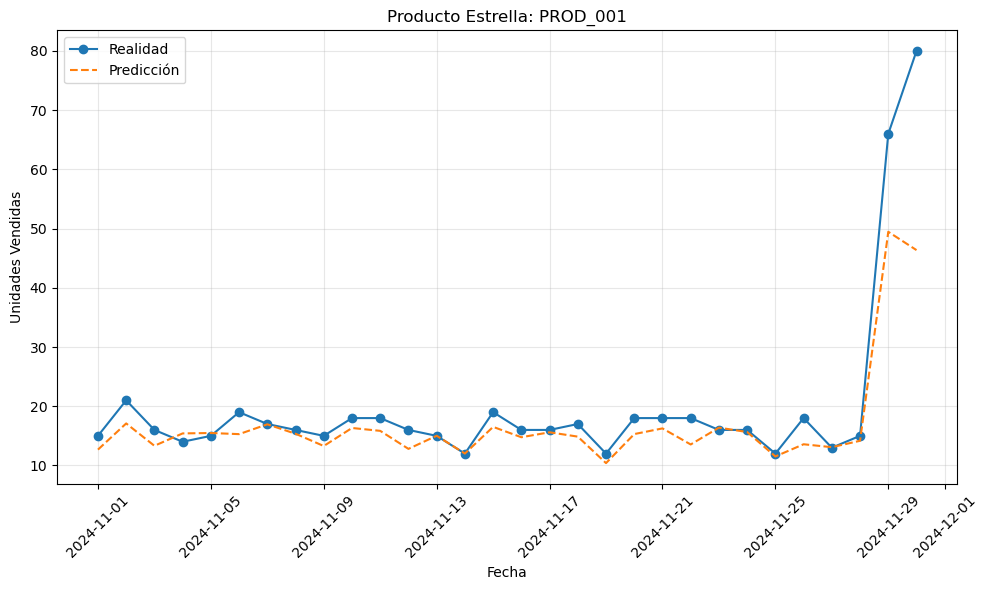

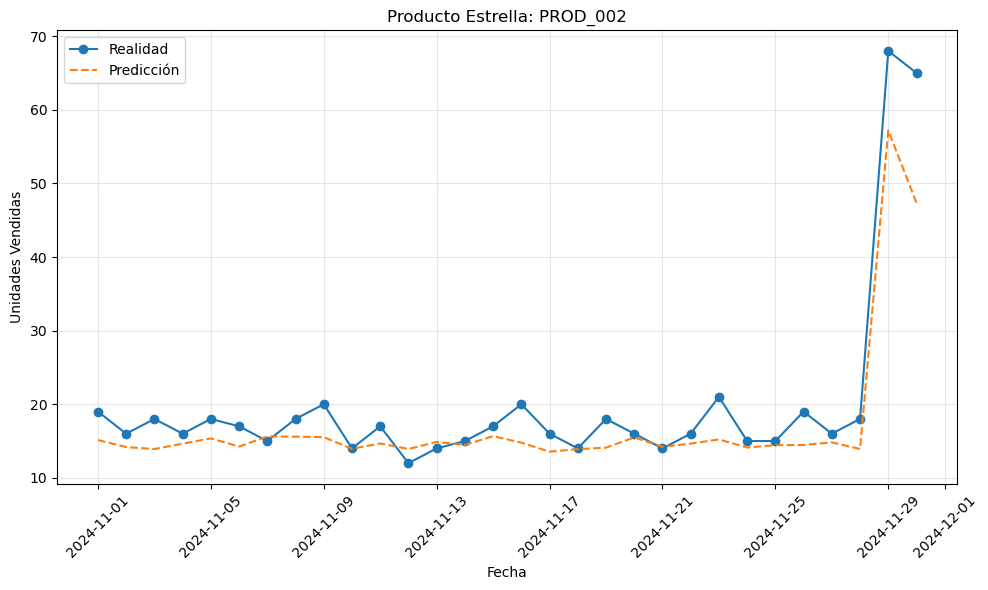

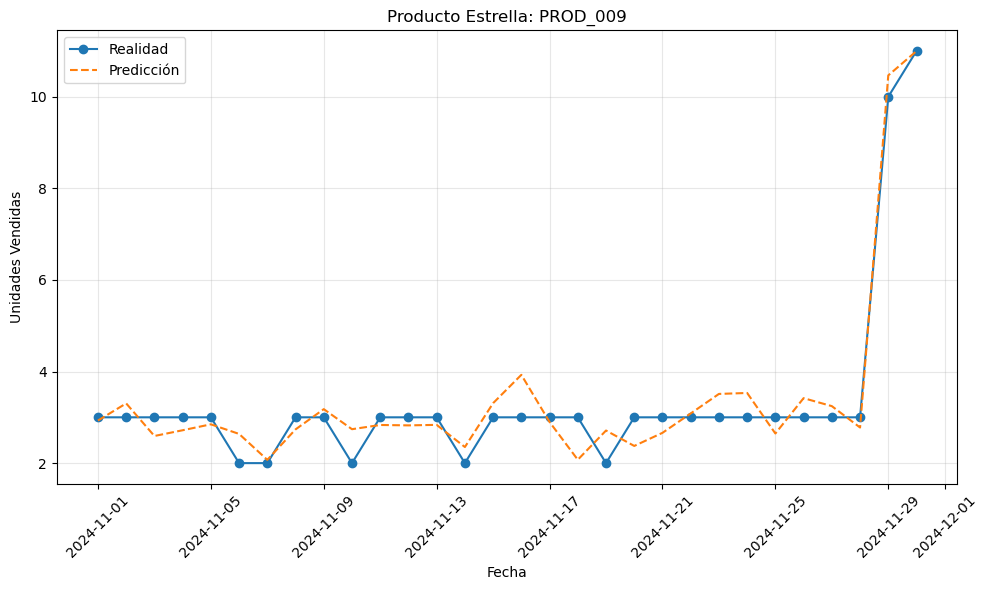

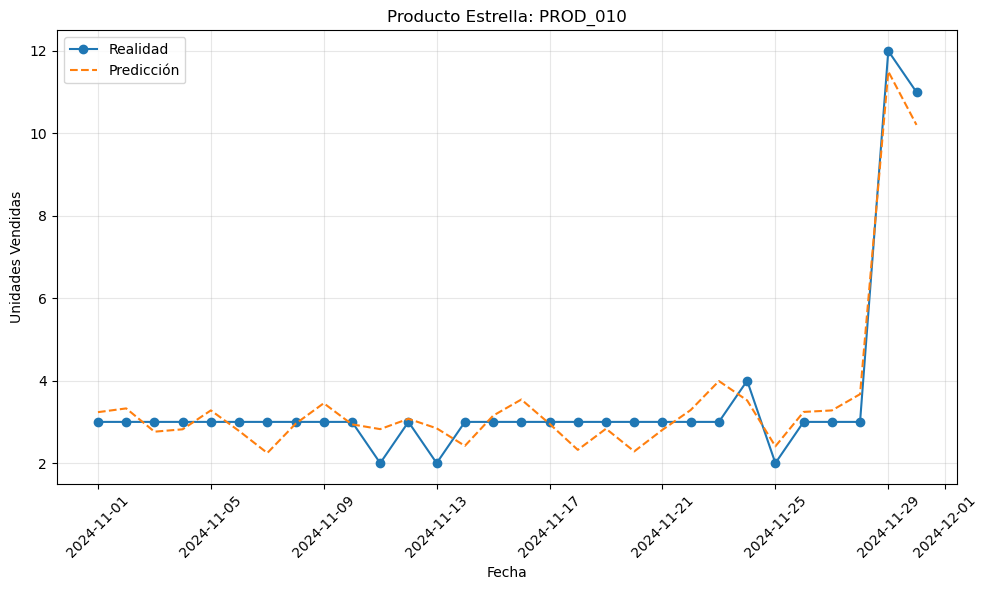

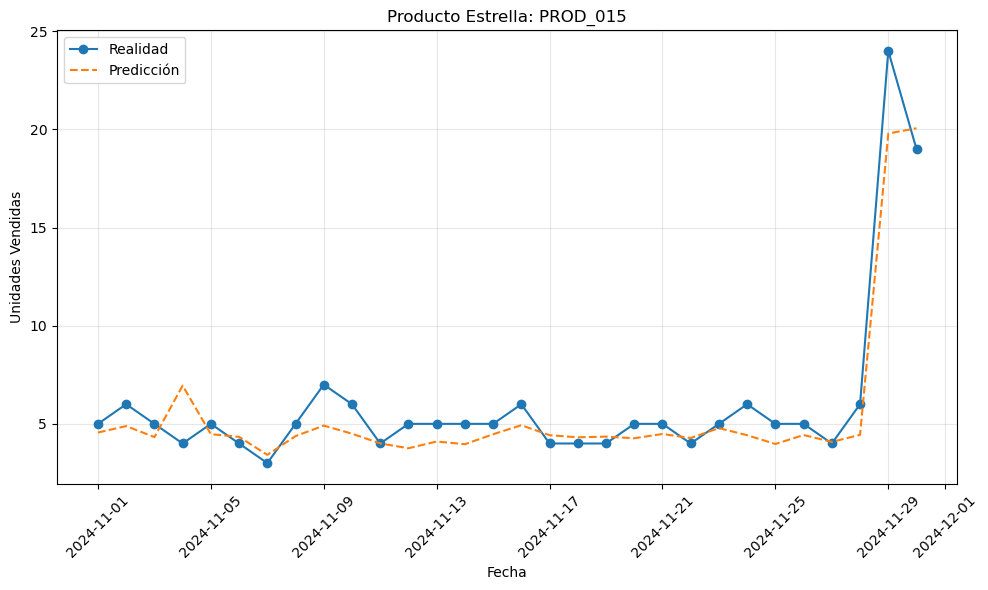

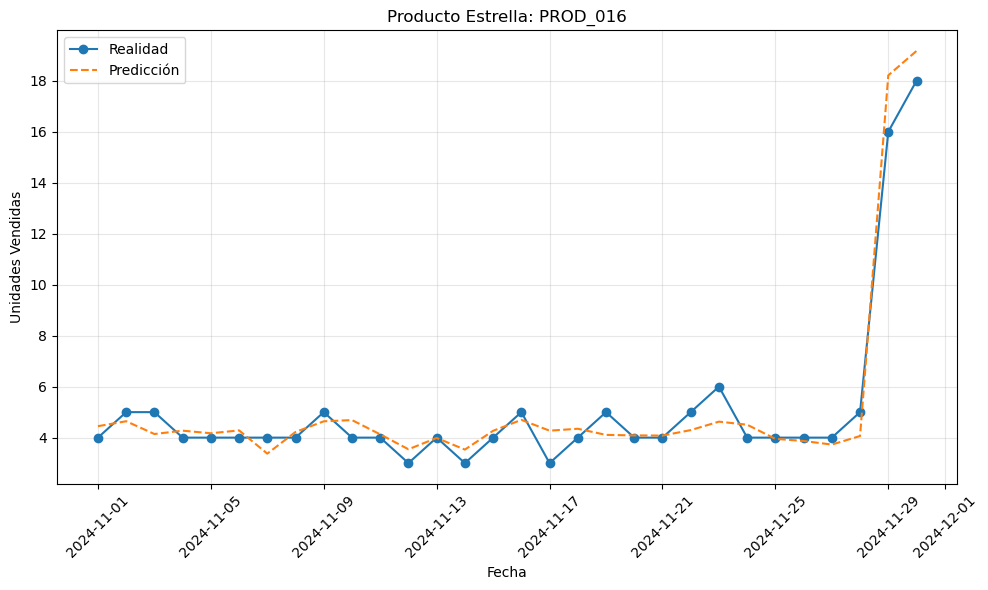

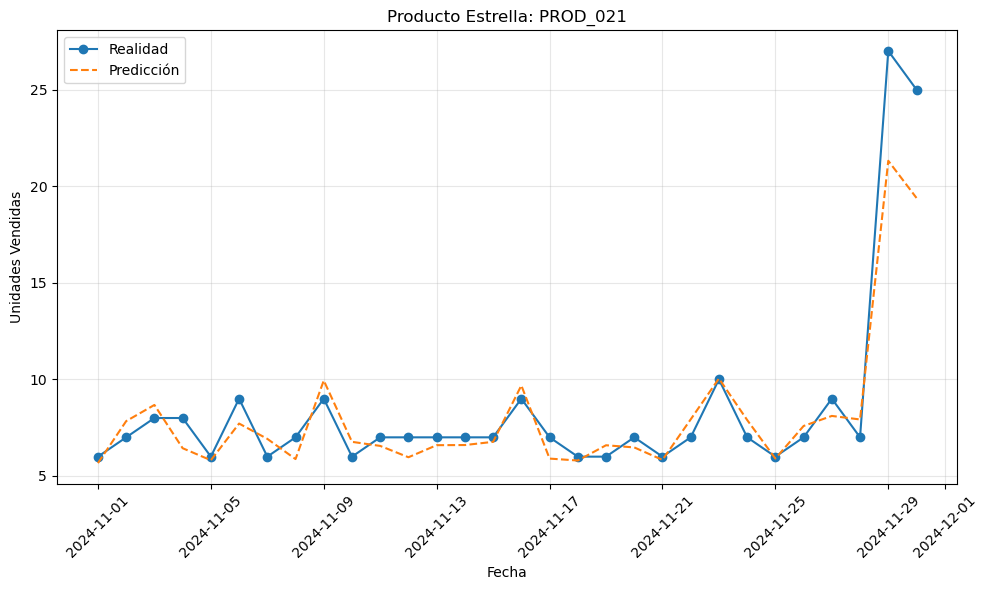

In [31]:
# ================================================
# PREDICCIONES PARA NOVIEMBRE 2024 Y GRÁFICOS POR PRODUCTO ESTRELLA
# ================================================
# Filtrar datos de noviembre 2024
df_nov_2024 = df_merged[(df_merged['anio'] == 2024) & (df_merged['mes'] == 11)]

# Filtrar productos estrella
productos_estrella = df_nov_2024[df_nov_2024['es_estrella'] == 1]['producto_id'].unique()

# Crear predicciones para noviembre 2024
X_nov_2024 = df_nov_2024[predictoras].select_dtypes(include=[np.number])
df_nov_2024['predicciones'] = modelo.predict(X_nov_2024)

# Generar gráficos para cada producto estrella
for producto in productos_estrella:
    df_producto = df_nov_2024[df_nov_2024['producto_id'] == producto]
    plt.figure(figsize=(10, 6))
    plt.plot(df_producto['fecha'], df_producto['unidades_vendidas'], label='Realidad', marker='o')
    plt.plot(df_producto['fecha'], df_producto['predicciones'], label='Predicción', linestyle='--')
    plt.title(f"Producto Estrella: {producto}")
    plt.xlabel("Fecha")
    plt.ylabel("Unidades Vendidas")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [32]:
# ================================================
# CÁLCULO DEL MAE PARA CADA PRODUCTO ESTRELLA
# ================================================
from sklearn.metrics import mean_absolute_error

# Calcular el MAE para cada producto estrella
mae_productos = {}
for producto in productos_estrella:
    df_producto = df_nov_2024[df_nov_2024['producto_id'] == producto]
    mae = mean_absolute_error(df_producto['unidades_vendidas'], df_producto['predicciones'])
    mae_productos[producto] = mae

# Mostrar el MAE para cada producto estrella
print("\n📊 MAE POR PRODUCTO ESTRELLA")
for producto, mae in mae_productos.items():
    print(f"Producto ID {producto}: MAE = {mae:.2f}")


📊 MAE POR PRODUCTO ESTRELLA
Producto ID PROD_001: MAE = 3.25
Producto ID PROD_002: MAE = 3.01
Producto ID PROD_009: MAE = 0.36
Producto ID PROD_010: MAE = 0.41
Producto ID PROD_015: MAE = 0.95
Producto ID PROD_016: MAE = 0.54
Producto ID PROD_021: MAE = 1.00


In [33]:
# ================================================
# MAE POR PRODUCTO ESTRELLA (usando producto_id pero mostrando nombre)
# ================================================
from sklearn.metrics import mean_absolute_error

mae_productos = {}

for producto in productos_estrella:
    df_producto = df_nov_2024[df_nov_2024['producto_id'] == producto]

    if len(df_producto) == 0:
        print(f"⚠️  No hay datos disponibles para el producto: {producto}")
        continue

    mae = mean_absolute_error(df_producto['unidades_vendidas'], df_producto['predicciones'])
    nombre = df_producto['nombre'].iloc[0]  # recuperamos el nombre real
    mae_productos[nombre] = mae

# Mostrar resultados ordenados por MAE
print("\n📊 MAE POR PRODUCTO ESTRELLA")
for nombre, mae in sorted(mae_productos.items(), key=lambda x: x[1]):
    print(f"{nombre}: MAE = {mae:.2f}")


📊 MAE POR PRODUCTO ESTRELLA
Bowflex SelectTech 552: MAE = 0.36
Domyos BM900: MAE = 0.41
Trek Marlin 7: MAE = 0.54
Salomon Speedcross 5 GTX: MAE = 0.95
Manduka PRO Yoga Mat: MAE = 1.00
Adidas Ultraboost 23: MAE = 3.01
Nike Air Zoom Pegasus 40: MAE = 3.25


📊 MÉTRICAS POR PERIODO (NOVIEMBRE 2024)


C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\59397087.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for periodo, grupo in df_periodos.groupby('periodo'):


,Periodo,MAE,RMSE,R2
1,Días 11–20,0.571529,0.849094,0.950766
0,Días 1–10,0.624506,0.942452,0.945421
2,Días 21–30,1.307372,3.243041,0.891411


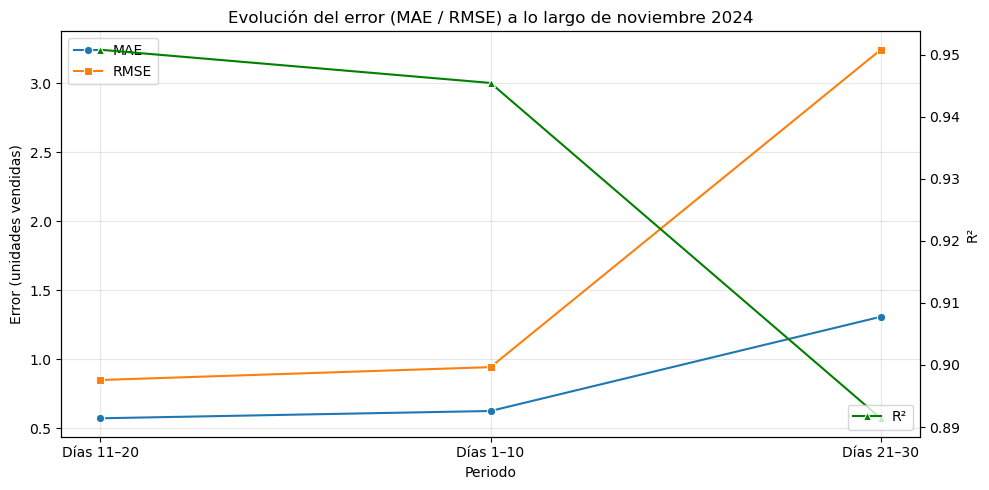

In [34]:
# ================================================
# ANÁLISIS DE DEGRADACIÓN DEL ERROR - NOVIEMBRE 2024
# ================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Aseguramos trabajar con el DataFrame con predicciones
df_periodos = df_nov_2024.copy()

# Crear variable de periodo (1–10, 11–20, 21–30)
df_periodos['periodo'] = pd.cut(
    df_periodos['fecha'].dt.day,
    bins=[0,10,20,31],
    labels=['Días 1–10','Días 11–20','Días 21–30']
)

# Calcular métricas por periodo
metricas = []
for periodo, grupo in df_periodos.groupby('periodo'):
    mae = mean_absolute_error(grupo['unidades_vendidas'], grupo['predicciones'])
    rmse = np.sqrt(mean_squared_error(grupo['unidades_vendidas'], grupo['predicciones']))
    r2 = r2_score(grupo['unidades_vendidas'], grupo['predicciones'])
    metricas.append({'Periodo': periodo, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

df_metricas = pd.DataFrame(metricas).sort_values('Periodo')

# Mostrar tabla resumen
print("📊 MÉTRICAS POR PERIODO (NOVIEMBRE 2024)")
display(df_metricas)

# Graficar evolución del error
fig, ax1 = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_metricas, x='Periodo', y='MAE', marker='o', label='MAE', ax=ax1)
sns.lineplot(data=df_metricas, x='Periodo', y='RMSE', marker='s', label='RMSE', ax=ax1)
ax1.set_ylabel('Error (unidades vendidas)')
ax1.set_title('Evolución del error (MAE / RMSE) a lo largo de noviembre 2024')
ax1.grid(alpha=0.3)
ax1.legend(loc='upper left')

# Eje secundario para R²
ax2 = ax1.twinx()
sns.lineplot(data=df_metricas, x='Periodo', y='R2', marker='^', color='green', label='R²', ax=ax2)
ax2.set_ylabel('R²')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\4074236708.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (producto, periodo), grupo in df_periodos_prod.groupby(['nombre','periodo']):


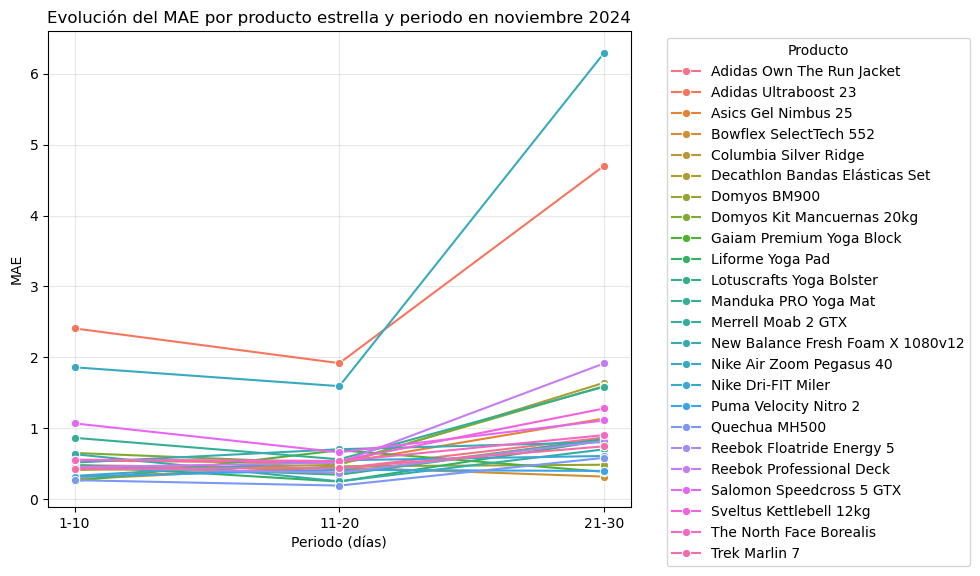

In [35]:
# ================================================
# EVOLUCIÓN DEL MAE POR PRODUCTO Y PERIODO EN NOVIEMBRE 2024
# ================================================
from sklearn.metrics import mean_absolute_error

# Copiamos el DF con predicciones
df_periodos_prod = df_nov_2024.copy()

# Crear variable de periodo (tres bloques de 10 días)
df_periodos_prod['periodo'] = pd.cut(
    df_periodos_prod['fecha'].dt.day,
    bins=[0,10,20,31],
    labels=['1-10','11-20','21-30']
)

# Calcular MAE por producto y periodo
metricas = []
for (producto, periodo), grupo in df_periodos_prod.groupby(['nombre','periodo']):
    if len(grupo) > 0:
        mae = mean_absolute_error(grupo['unidades_vendidas'], grupo['predicciones'])
        metricas.append({'Producto': producto, 'Periodo': periodo, 'MAE': mae})

df_metricas_prod = pd.DataFrame(metricas)

# Ordenar periodos y productos
df_metricas_prod['Periodo'] = pd.Categorical(df_metricas_prod['Periodo'], categories=['1-10','11-20','21-30'], ordered=True)

# === Gráfico ===
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_metricas_prod,
    x='Periodo',
    y='MAE',
    hue='Producto',
    marker='o'
)

plt.title('Evolución del MAE por producto estrella y periodo en noviembre 2024')
plt.xlabel('Periodo (días)')
plt.ylabel('MAE')
plt.legend(title='Producto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [36]:
df_metricas_prod[df_metricas_prod['Periodo'] == '21-30'].sort_values('MAE', ascending=False)

,Producto,Periodo,MAE
44,Nike Air Zoom Pegasus 40,21-30,6.293413
5,Adidas Ultraboost 23,21-30,4.701931
59,Reebok Professional Deck,21-30,1.913544
17,Decathlon Bandas Elásticas Set,21-30,1.641354
23,Domyos Kit Mancuernas 20kg,21-30,1.593049
35,Manduka PRO Yoga Mat,21-30,1.583804
65,Sveltus Kettlebell 12kg,21-30,1.278036
8,Asics Gel Nimbus 25,21-30,1.136391
62,Salomon Speedcross 5 GTX,21-30,1.109027
68,The North Face Borealis,21-30,0.902452


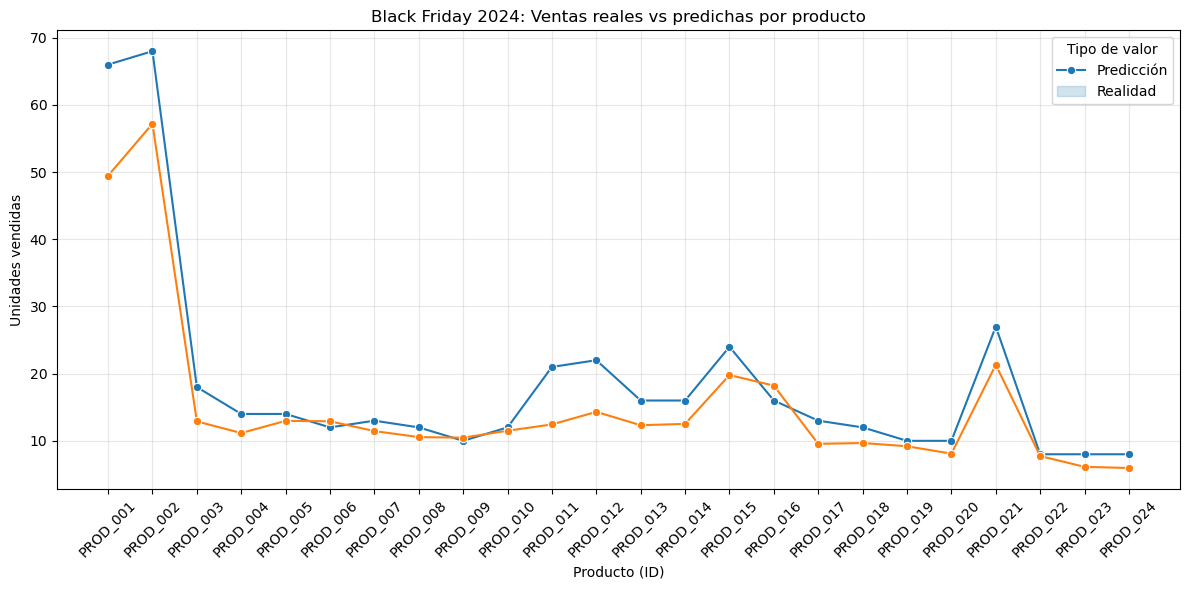

In [37]:
# ================================================
# ANÁLISIS DEL BLACK FRIDAY 2024 (2024-11-29)
# ================================================
# Filtrar solo el día del Black Friday
black_friday_2024 = df_nov_2024[df_nov_2024['fecha'] == '2024-11-29'].copy()

# Asegurar orden consistente de productos (por ID o nombre)
black_friday_2024 = black_friday_2024.sort_values('producto_id')

# Crear DataFrame largo (melt) para comparar Real vs Predicho
df_bf_long = black_friday_2024.melt(
    id_vars=['producto_id', 'nombre'],
    value_vars=['unidades_vendidas', 'predicciones'],
    var_name='Tipo',
    value_name='Unidades'
)

# === Gráfico ===
plt.figure(figsize=(12,6))
sns.lineplot(
    data=df_bf_long,
    x='producto_id',
    y='Unidades',
    hue='Tipo',
    marker='o'
)
plt.title('Black Friday 2024: Ventas reales vs predichas por producto')
plt.xlabel('Producto (ID)')
plt.ylabel('Unidades vendidas')
plt.xticks(rotation=45)
plt.legend(title='Tipo de valor', labels=['Predicción','Realidad'])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [38]:
# ================================================
# ENTRENAMIENTO FINAL DEL MODELO CON TODO EL HISTÓRICO (2021–2024)
# ================================================
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

# 1️⃣ Aseguramos que la columna objetivo y predictoras estén definidas igual que antes
columnas_excluir = ['fecha', 'ingresos', 'unidades_vendidas']
columnas_excluir = [col for col in columnas_excluir if col in df_merged.columns]

# Seleccionar las columnas predictoras (idénticas al modelo anterior)
predictoras = df_merged.select_dtypes(exclude=['object', 'datetime']).drop(columns=columnas_excluir, errors='ignore').columns

# 2️⃣ Definir X e y con todos los datos históricos
X_final = df_merged[predictoras]
y_final = df_merged['unidades_vendidas']

print(f"✅ Datos de entrenamiento: {X_final.shape[0]} filas, {X_final.shape[1]} variables predictoras.")

# 3️⃣ Configurar el modelo con los mismos parámetros óptimos
model_final = HistGradientBoostingRegressor(
    learning_rate=0.01,
    max_iter=200,
    max_depth=6,
    min_samples_leaf=20,
    l2_regularization=1.0,
    random_state=42
)

# 4️⃣ Entrenar el modelo final
model_final.fit(X_final, y_final)

print("\n✅ Modelo final entrenado correctamente con todo el histórico (2021–2024).")


✅ Datos de entrenamiento: 3524 filas, 69 variables predictoras.

✅ Modelo final entrenado correctamente con todo el histórico (2021–2024).


🔍 Calculando importancia de variables (Permutation Importance)...


C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\2693827572.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


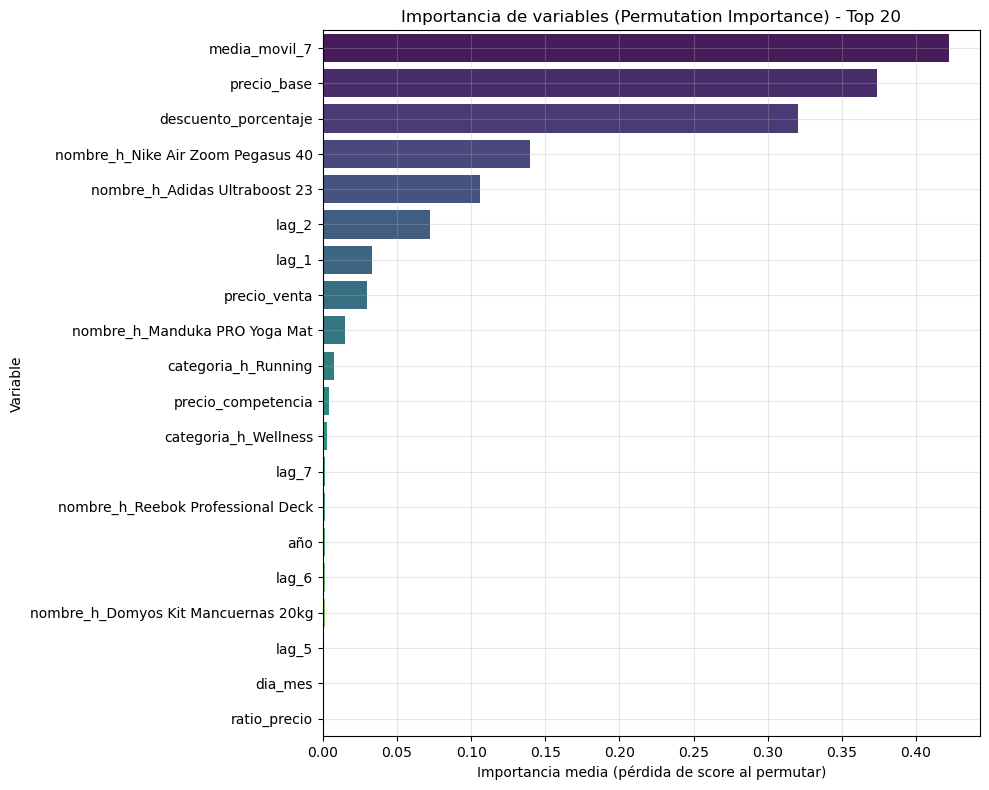

In [39]:
# ================================================
# IMPORTANCIA DE VARIABLES (PERMUTATION IMPORTANCE) Y GUARDADO DEL MODELO FINAL
# ================================================
from sklearn.inspection import permutation_importance
import joblib
import os

# 1️⃣ Calcular la importancia de variables mediante permutation importance
#    (usamos el mismo X_final e y_final del entrenamiento final)
print("🔍 Calculando importancia de variables (Permutation Importance)...")
perm_importance = permutation_importance(
    model_final,
    X_final,
    y_final,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 2️⃣ Crear DataFrame ordenado por importancia
importancias_df = (
    pd.DataFrame({
        'Variable': X_final.columns,
        'Importancia': perm_importance.importances_mean
    })
    .sort_values('Importancia', ascending=False)
)

# 3️⃣ Graficar importancias (horizontal barplot)
plt.figure(figsize=(10, 8))
sns.barplot(
    data=importancias_df.head(20),  # top 20 más relevantes
    y='Variable',
    x='Importancia',
    palette='viridis'
)
plt.title('Importancia de variables (Permutation Importance) - Top 20')
plt.xlabel('Importancia media (pérdida de score al permutar)')
plt.ylabel('Variable')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#PARA GUARDAR EL MODELO FINAL DESCOMENTAR ESTAS LÍNEAS:

# 4️⃣ Guardar el modelo final en la carpeta /models
# ruta_modelo = os.path.join("models", "modelo_final.joblib")
# os.makedirs(os.path.dirname(ruta_modelo), exist_ok=True)
# joblib.dump(model_final, ruta_modelo)

# print(f"✅ Modelo final guardado correctamente en: {ruta_modelo}")

C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\2336425334.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importancias_top20['Variable'] = importancias_top20['Variable'].str.replace('nombre_h_', '', regex=False)
C:\Users\heatb\AppData\Local\Temp\ipykernel_10148\2336425334.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


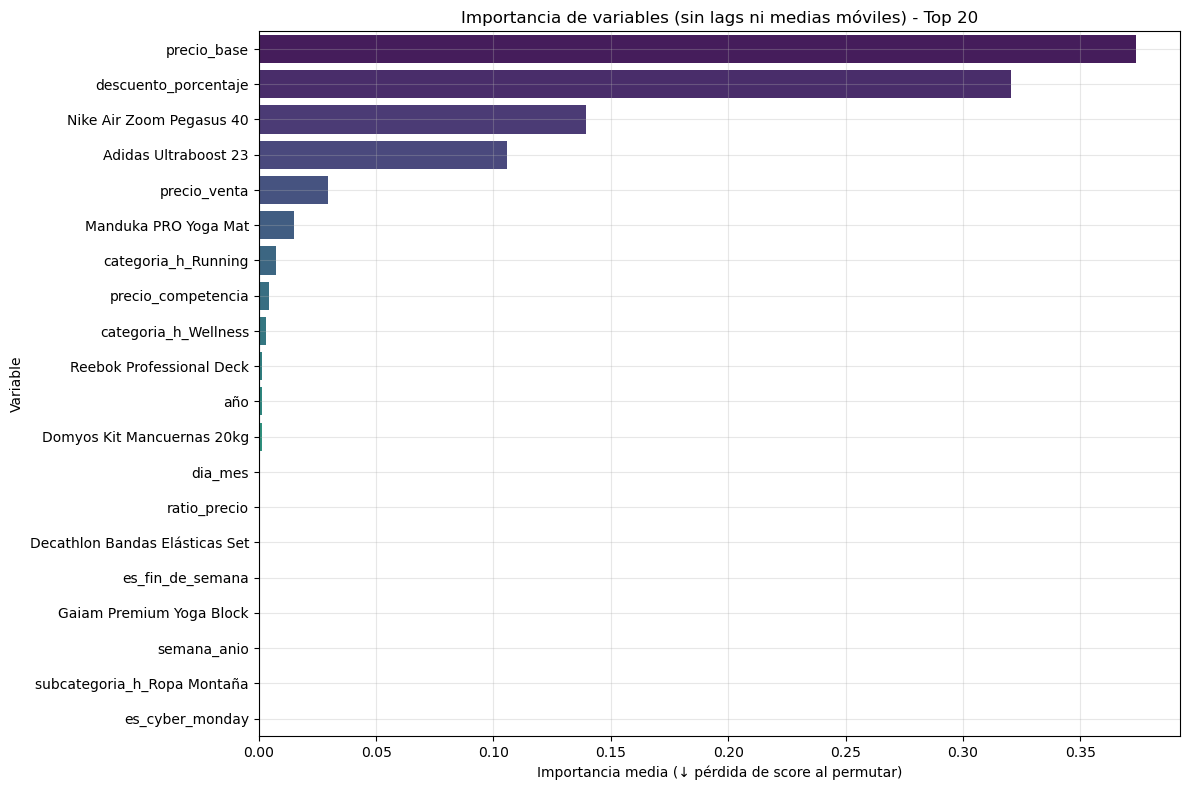

In [41]:
# ===================================================
# IMPORTANCIA DE VARIABLES SIN LAGS NI MEDIAS MÓVILES
# ===================================================

# 1) Filtrar OUT lo que NO queremos: lag_* y media_movil_* (o rolling_*)
variables_excluir = importancias_df[
    importancias_df['Variable'].str.startswith(('lag_', 'media_movil', 'rolling'))
]['Variable'].tolist()

importancias_filtrado = importancias_df[
    ~importancias_df['Variable'].isin(variables_excluir)
].copy()

# 2) Ordenar las variables por importancia
importancias_filtrado = importancias_filtrado.sort_values('Importancia', ascending=False)

# 3) Seleccionar top 20
importancias_top20 = importancias_filtrado.head(20)

# 4) Limpiar etiquetas (opcional): quitar prefijo nombre_h_
importancias_top20['Variable'] = importancias_top20['Variable'].str.replace('nombre_h_', '', regex=False)

# 5) Graficar
plt.figure(figsize=(12, 8))
sns.barplot(
    data=importancias_top20,
    y='Variable',
    x='Importancia',
    palette='viridis'
)
plt.title('Importancia de variables (sin lags ni medias móviles) - Top 20')
plt.xlabel('Importancia media (↓ pérdida de score al permutar)')
plt.ylabel('Variable')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
